# In-Depth Analysis 

## Loading Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split 

## Importing the data

In [2]:
recipes_df=pd.read_csv('recipes_df.csv')
recipes_df.set_index('id', inplace=True)
reviews_df=pd.read_csv('reviews_df.csv')
reviews_df.set_index('recipe_id', inplace=True)
tags_matrix=pd.read_csv('tags_matrix.csv')
tags_matrix.set_index('id', inplace=True)
ingredients_matrix=pd.read_csv('ingredients_matrix.csv')
ingredients_matrix.set_index('id', inplace=True)

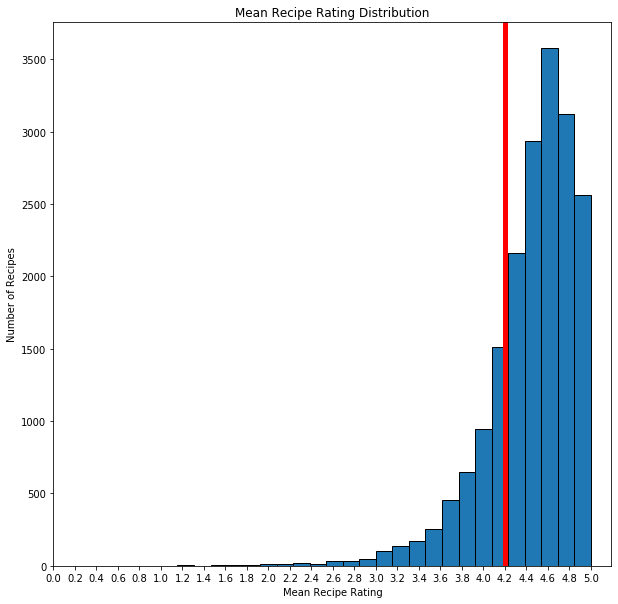

In [3]:
_ = plt.figure(figsize=(10,10))
x_range=[0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,
         2.0,2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,
         4.0,4.2,4.4,4.6,4.8,5.0]
_ = plt.hist(reviews_df.groupby('recipe_id')['rating'].mean(), edgecolor='black', bins=25)#(len(x_range)-1)#np.arange(, 5, 0.20))
_ = plt.title('Mean Recipe Rating Distribution')
_ = plt.xlabel('Mean Recipe Rating')
_ = plt.ylabel('Number of Recipes')
_ = plt.xticks(x_range)
_ = plt.axvline(x=4.2, linewidth=5, color='r')

Based on the histogram above we decided to arbitrarily choose a mean rating of 4.2 as a threshold for "good" vs "bad" recipes.

In [4]:
print('Number of "good" recipes with rating >=4.2 = '
      +str(len(reviews_df.index[reviews_df.rating>=4.2]))+'\n'
      +'Number of "bad" recipes with rating < 4.2 = '
      +str(len(reviews_df.index[reviews_df.rating < 4.2])))

Number of "good" recipes with rating >=4.2 = 434232
Number of "bad" recipes with rating < 4.2 = 143605


There are 3 times more recipes labeled as "good", so we have a class imbalance situation. It will impact our choice of model accuracy metrics later.

## Predicting Recipe Rating by Recipe Tags Using Naive Bayes

We learned from the data analysis before that the recipe tags is one of the features of the recipes dataset, and that recipes with 'pressure-canning' tag has the worst rating.<br>
We will dive deeper now and build a model to predict the recipe rating above or below 4.2 by  recipe tags.

In order to create the word vectors for all the tags present in a recipe, we can use tags_matrix with average recipe ratings that we built earlier.

In [5]:
avg_rating=reviews_df.groupby('recipe_id')['rating'].mean()
tags_matrix_rating=tags_matrix.join(avg_rating, how='left')
tags_matrix_rating.head(3)

,'crusts-pastry-dough-2','april-fools-day','marinades-and-rubs','turkish','oamc-freezer-make-ahead','gifts','cooking-mixes','indonesian','breads','60-minutes-or-less',...,'spreads','tropical-fruit','cauliflower','canning','15-minutes-or-less','mixer','chowders','pressure-canning','plums',rating
id,,,,,,,,,,,,,,,,,,,,,
63986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.368421
43026,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.045455
23933,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.833333


### Naive Bayes

Let's use multinomial Naive Bayes model to predict if the recipe rating is >= 4.2. (We want to predict a category with labelled data and over 100K samples of text data, so it is appropriate to use this model.)

In [6]:
X=tags_matrix_rating.iloc[:,:-1].values
y=(tags_matrix_rating.rating >= 4.2).values.astype(np.float)

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, random_state=42) 
multinom = MultinomialNB()
multinom.fit(X_train,y_train)
y_pred = multinom.predict(X_test)


from sklearn.metrics import confusion_matrix, classification_report
print("Classification Report:\n\n",classification_report(y_test, y_pred, labels=[0, 1]))
print("\nConfusion Matrix:\n\n",confusion_matrix(y_test, y_pred))
#training_accuracy = multinom.fit(X_train,y_train).score(X_train,y_train)
#test_accuracy = multinom.fit(X_test,y_test).score(X_test,y_test)
#print("Accuracy on training data: {:2f}".format(training_accuracy))
#print("Accuracy on test data:     {:2f}".format(test_accuracy))

Classification Report:

               precision    recall  f1-score   support

           0       0.33      0.15      0.21      1166
           1       0.81      0.92      0.86      4463

    accuracy                           0.76      5629
   macro avg       0.57      0.54      0.53      5629
weighted avg       0.71      0.76      0.72      5629


Confusion Matrix:

 [[ 180  986]
 [ 367 4096]]


The regular accuracy score is not a good metri to determine goodness of our model, because we have a class imbalance situation. F1 score will be a better metric, as it balances precision and recall.<br>
From the confusion matrix that our model provides a good number of True Negatives (4,096), but also provides more False Positives than True Positives (367 > 180).<br>
From the classification report we can see that the F1 score for prediction on the test data is 86%, which is higher than the F1 score on the training data (21%).

In order to improve the model accuracy, we need to tune the hyperparameters: min_df and alpha.<br>
- min_df represents the minimum number of recipes a tag must appear in for it to be included in the vocabulary <br>
- alpha acts as a pseudo count for unseen tags. If alpha is too high, we will assign higher prior probability to unseen tags and add more bias towards the appearance of unseen tags

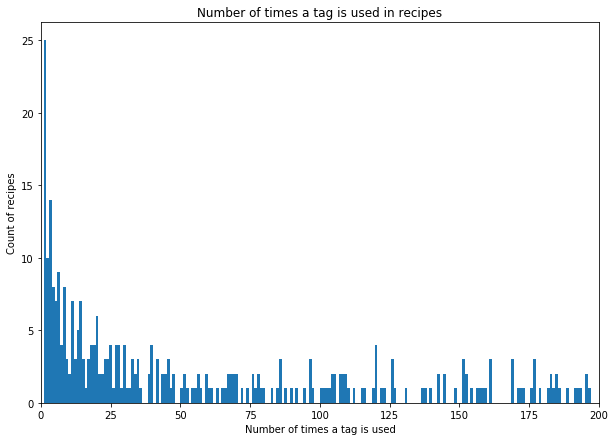

In [7]:
tags_count = tags_matrix_rating.drop('rating', axis = 1).sum(axis = 0)
fig, ax = plt.subplots(figsize = (10, 7))
ax.hist(tags_count.loc[tags_count < 200, ], bins = 200)
_ = plt.xlabel('Number of times a tag is used')
_ = plt.ylabel('Count of recipes')
_ = plt.title('Number of times a tag is used in recipes')
ax.set_xlim(0, 200)
plt.show()

There are very many tags that appear only one time. Intuition tells that us those aren't valuable. Let's drop the tags that are present in only 2 recipes or less and rerun the model.

In [29]:
tags_matrix_rating1 = tags_matrix_rating.drop(tags_count[tags_count < 3].index, axis = 1)
tags_matrix_rating1.head(3)

,'crusts-pastry-dough-2','marinades-and-rubs','turkish','oamc-freezer-make-ahead','gifts','cooking-mixes','indonesian','breads','60-minutes-or-less','penne',...,'spreads','tropical-fruit','cauliflower','canning','15-minutes-or-less','mixer','chowders','pressure-canning','plums',rating
id,,,,,,,,,,,,,,,,,,,,,
63986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.368421
43026,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,4.045455
23933,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.833333


In [30]:
X1=tags_matrix_rating1.iloc[:,:-1].values
y1=(tags_matrix_rating1.rating >= 4.2).values.astype(np.float)

X_train, X_test, y_train, y_test = train_test_split(X1, y1,
                                                    test_size = 0.3, random_state=42) 
multinom = MultinomialNB()
multinom.fit(X_train,y_train)
y_pred = multinom.predict(X_test)
multinom.score(X_test, y_test)


from sklearn.metrics import confusion_matrix, classification_report
print("Classification Report:\n\n",classification_report(y_test, y_pred, labels=[0, 1]))
print("\nConfusion Matrix:\n\n",confusion_matrix(y_test, y_pred))

Classification Report:

               precision    recall  f1-score   support

           0       0.34      0.16      0.22      1166
           1       0.81      0.92      0.86      4463

    accuracy                           0.76      5629
   macro avg       0.57      0.54      0.54      5629
weighted avg       0.71      0.76      0.73      5629


Confusion Matrix:

 [[ 185  981]
 [ 365 4098]]


By removing the tags present in less than 3 recipes the F1 score improved slightly on the training data (21% to 22%) and did not improve on the test data. 

Alpha is chosen to be a small value that simply avoids having zeros in the probability computations. We will use K-fold cross validation to find the best parameter alpha. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [10]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

In [11]:
def log_likelihood(clf, X, y):
    prob = clf.predict_log_proba(X)
    bad = y == 0
    good = ~bad
    return prob[bad, 0].sum() + prob[good, 1].sum()

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
def make_xy(df, vectorizer=None):#CountVectorizer()):    
    #X = vectorizer.fit_transform(df.iloc[:,:-1])
    X = np.array(tags_matrix_rating.iloc[:,:-1])
    #X = X.tocsc()  # some versions of sklearn return COO format
    y = (df.rating >= 4.2).values.astype(np.float)
    return X, y
X, y = make_xy(tags_matrix_rating)

In [13]:
X.shape

(18762, 495)

In [14]:
y.shape

(18762,)

In [15]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(tags_matrix_rating.shape[0]), train_size=0.7)
mask = np.zeros(tags_matrix_rating.shape[0], dtype=np.bool)
mask[itest] = True

We will now cross-validate over the regularization parameter alpha.

In [32]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 3 # value of best min_df 

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
accuracy = []
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(tags_matrix_rating, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    #model to be used
    mlb = MultinomialNB(alpha=alpha)
    #fitting data
    accuracy.append(cv_score(mlb,Xtrainthis,ytrainthis,log_likelihood))
accuracy_alpha = dict(zip(alphas,accuracy))
accuracy_alpha

{0.1: -690.3019932618802,
 1: -664.4383922997715,
 5: -673.2055520443728,
 10: -764.5360703482542,
 50: -1790.2611910538712}

In [33]:
best_alpha = max(accuracy_alpha,key=accuracy_alpha.get)
print("best alpha: {}".format(best_alpha))

best alpha: 1


Let's calculate the accuracy on the training and test sets using the best value of `alpha`=1 

In [35]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(tags_matrix_rating, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

from sklearn.metrics import confusion_matrix, classification_report
print("Classification Report:\n\n",classification_report(y_test, y_pred, labels=[0, 1]))
print("\nConfusion Matrix:\n\n",confusion_matrix(y_test, y_pred))

Classification Report:

               precision    recall  f1-score   support

           0       0.34      0.16      0.22      1166
           1       0.81      0.92      0.86      4463

    accuracy                           0.76      5629
   macro avg       0.57      0.54      0.54      5629
weighted avg       0.71      0.76      0.73      5629


Confusion Matrix:

 [[ 185  981]
 [ 365 4098]]


After tuning in the hyperparameters, the model improved slightly with F1 score improvement of 1% on the training data and the number of True Positives increasing from 180 to 185. 

## Random Forest

Let's now predict recipe rating using a Random Forest Classifier.  
We need to create a combined_df containing all the feature columns first.

In [19]:
combined_df=recipes_df[['minutes','n_steps','Calories','Total Fat','Sugars',
           'Sodium','Protein','Saturated Fat',
            'Total Carbohydrate']].merge(ingredients_matrix, right_index=True,left_index=True)
combined_df=combined_df.merge(tags_matrix,right_index=True,left_index=True)
combined_df=combined_df.join(avg_rating, how='left')
combined_df.head(3)

,minutes,n_steps,Calories,Total Fat,Sugars,Sodium,Protein,Saturated Fat,Total Carbohydrate,flour,...,'spreads','tropical-fruit','cauliflower','canning','15-minutes-or-less','mixer','chowders','pressure-canning','plums',rating
id,,,,,,,,,,,,,,,,,,,,,
63986,500,5,105.7,8.0,0.0,26.0,5.0,4.0,3.0,1,...,0,0,0,0,0,0,0,0,0,4.368421
43026,45,9,94.0,10.0,0.0,11.0,11.0,21.0,0.0,0,...,0,0,0,0,0,0,0,0,0,4.045455
23933,15,4,232.7,21.0,77.0,4.0,6.0,38.0,8.0,0,...,0,0,0,0,0,0,0,0,0,4.833333


Now we have data with 653 features. We need to perform PCA dimension reduction to get rid of "noisy" features that don't add predictive value.

### PCA Dimension Reduction

Let's define how many intrinsic dimensions we need. (We will standardize the features first using the StandardScaler())

In [20]:
samples=combined_df.iloc[:,:-1].values

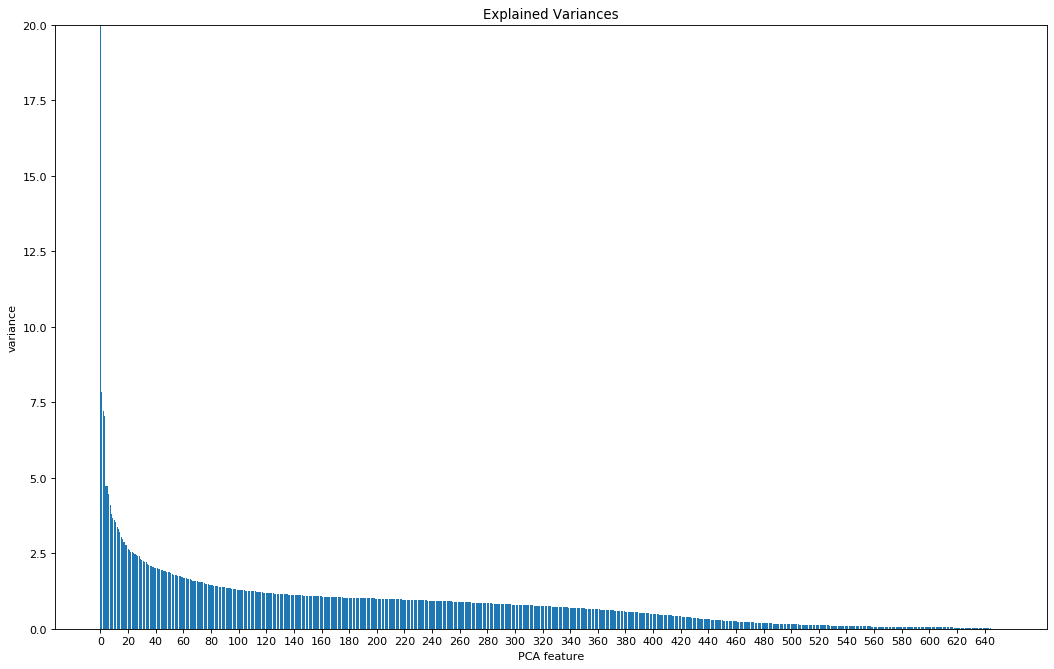

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(samples)
features = range(pca.n_components_)
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
plt.bar(features, pca.explained_variance_)
plt.ylim(0,20)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.title('Explained Variances')
plt.xticks(range(0,654,20))
plt.show()

As we can see from the plot above, most features do not explain more than 2.5% of the variance, with 1 feature being highly descriptive and explaining power dropping after 20 features. So, we can make a conclusion that there are 20 intrinsic dimensions. Now let's perform dimension reduction of the data using PCA

In [22]:
pca = PCA(n_components=20)
pca.fit(samples)
pca_features = pca.transform(samples)
print(pca_features.shape)

(18762, 20)


Now let's use a Random Forest classifier on the pca_features to classify the recipes as "good" (e.g. average rating > 4.2) or "bad".

In [23]:
combined_df['rating1'] = combined_df.rating.apply(lambda x: 1 if x >= 4.2 else 0)
combined_df.head(3)

,minutes,n_steps,Calories,Total Fat,Sugars,Sodium,Protein,Saturated Fat,Total Carbohydrate,flour,...,'tropical-fruit','cauliflower','canning','15-minutes-or-less','mixer','chowders','pressure-canning','plums',rating,rating1
id,,,,,,,,,,,,,,,,,,,,,
63986,500,5,105.7,8.0,0.0,26.0,5.0,4.0,3.0,1,...,0,0,0,0,0,0,0,0,4.368421,1
43026,45,9,94.0,10.0,0.0,11.0,11.0,21.0,0.0,0,...,0,0,0,0,0,0,0,0,4.045455,0
23933,15,4,232.7,21.0,77.0,4.0,6.0,38.0,8.0,0,...,0,0,0,0,0,0,0,0,4.833333,1


In [36]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
X=pca_features
y=combined_df.rating1.values.astype(np.int)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, random_state=42)

y_pred = rf.fit(X_train,y_train).predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report
print("Classification Report:\n\n",classification_report(y_test, y_pred, labels=[0, 1]))
print("\nConfusion Matrix:\n\n",confusion_matrix(y_test, y_pred))

C:\Users\anna_\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classification Report:

               precision    recall  f1-score   support

           0       0.30      0.14      0.19      1166
           1       0.80      0.91      0.85      4463

    accuracy                           0.75      5629
   macro avg       0.55      0.53      0.52      5629
weighted avg       0.70      0.75      0.72      5629


Confusion Matrix:

 [[ 168  998]
 [ 398 4065]]


Random Forest model's F1 scores are slightly worse than those of tuned in Naive Bayes model (19% vs 22% on the training data, 85% vs 86% on the test data). The number of True Positives is higher in Random Forest (398 vs 365), but the number of True Negatives is lower (4,065 vs 4,098)

Let's see if we can improve Random Forest model's predictions by tuning in the hyperparameters. There are many poarameters that can be tuned for these model, but we chose to start with the number of trees in the forest: n_estimators (default is 10 in our version of sklearn). We will use F1 score as our accuracy metric.

In [75]:
n_estimators = [10, 20, 50, 100]
accuracy_f1 = []
for estimators in n_estimators:
    rf = RandomForestClassifier(n_estimators = estimators)
    y_pred = rf.fit(X_train,y_train).predict(X_test)
    accuracy_f1.append(f1_score(y_test, y_pred, average=None))

accuracy_f1_dict = dict(zip(n_estimators,accuracy_f1))
accuracy_f1_dict

{10: array([0.17446563, 0.85000525]),
 20: array([0.11921459, 0.87225386]),
 50: array([0.04769475, 0.8802    ]),
 100: array([0.02980132, 0.88338308])}

In [76]:
rf = RandomForestClassifier(n_estimators = 100)
y_pred = rf.fit(X_train,y_train).predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print("Classification Report:\n\n",classification_report(y_test, y_pred, labels=[0, 1]))
print("\nConfusion Matrix:\n\n",confusion_matrix(y_test, y_pred))

Classification Report:

               precision    recall  f1-score   support

           0       0.33      0.01      0.03      1166
           1       0.79      0.99      0.88      4463

    accuracy                           0.79      5629
   macro avg       0.56      0.50      0.45      5629
weighted avg       0.70      0.79      0.71      5629


Confusion Matrix:

 [[  17 1149]
 [  35 4428]]


Random Forest model with 100 trees produces the best F1 score on the test data of 88%. <br>